In [605]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

% matplotlib inline

In [606]:
# tabela_final = pd.read_csv('tabela_final_prod.csv')
tabela_final = pd.read_csv('tabela_final_prod.csv')

In [607]:
columns = [column for column in tabela_final.columns if column != 'municipio']

for column in tabela_final[columns]:
    tabela_final[column] = tabela_final[column].replace('-', np.nan)
    tabela_final[column] = tabela_final[column].astype('float64')

In [608]:
tabela_final = tabela_final.loc[tabela_final.municipio != 'Fernando de Noronha']
tabela_final = tabela_final.loc[tabela_final.municipio != 'Recife']
# tabela_final = tabela_final.loc[tabela_final.municipio != 'Agua Preta']
# tabela_final = tabela_final.loc[tabela_final.municipio != 'Recife']

for column in tabela_final.columns:
    if 'total' in column or '(%)' in column:
        tabela_final.drop(column, axis=1, inplace=True)

In [609]:
tabela_final.set_index('municipio',inplace=True)
tabela_final = tabela_final.fillna(0)

In [610]:
not_in_columns = ['pop','taxa_homicidio']

In [611]:
which_columns = []
x = tabela_final['taxa_homicidio'].values
for column in tabela_final.columns:
    if (column not in not_in_columns):
        y = tabela_final[column].values
        model = linregress(x,y)
        if (model.pvalue <= 0.000000001):
            which_columns.append(column)

In [612]:
#8 0.00000000001

print(len(which_columns))
# which_columns.append('taxa_homicidio')
which_columns

4


['pessoas_de_10_anos_ou_mais_de_idade_grupos_de_anos_de_estudo_1_a_3_anos',
 'pessoas_de_10_anos_ou_mais_de_idade_empregadas_no_trabalho_principal_da_semana_de_referencia_subgrupo_do_emprego_no_trabalho_principal_trabalhadores_domesticos_categoria_do_emprego_no_trabalho_principal__sem_carteira_de_trabalho_assinada',
 'pessoas_de_10_anos_ou_mais_de_idade_empregadas_no_trabalho_principal_da_semana_de_referencia_subgrupo_do_emprego_no_trabalho_principal_demais_empregados_categoria_do_emprego_no_trabalho_principal__outros_sem_carteira_de_trabalho_assinada_(1)',
 'valor_do_rendimento_nominal_mediano_mensal_do_trabalho_principal_das_pessoas_de_10_anos_ou_mais_de_idade_ocupadas_na_semana_de_referencia_com_rendimento_no_trabalho_principal_(r$)__posicao_na_ocupacao_no_trabalho_principal_empregados_categoria_do_emprego_no_trabalho_principal_outros_sem_carteira_de_trabalho_assinada_(1)']

In [613]:
#copiar tabela
tb_signifi = tabela_final

In [614]:
#criando uma nova só com as variaveis que passaram pelo p-value
for column in tb_signifi.columns:
    if (column not in which_columns and column != 'pop' and column != 'taxa_homicidio'):
        tb_signifi = tb_signifi.drop([column],1)

In [615]:
#tb_signifi

In [616]:
tb_signifi.to_csv('deus.csv', index=False)

In [617]:
#normalizando a tabela
for column in tb_signifi.columns:
    if ('(%)' not in column):
        tb_signifi[column] = tb_signifi[column].apply(lambda x: x * 100000 / tb_signifi['pop'])
        tb_signifi[column] = tb_signifi[column].apply(lambda x: (x - tb_signifi[column].min()) / (tb_signifi[column].max() - tb_signifi[column].min()) ) #normalizacao min-max
#         tb_signifi[column] = tb_signifi[column].apply(lambda x: np.log10(x))  
        #df[column] = df[column].apply(lambda x: (x - df[column].mean()) / df[column].std())  #normalizacao zscore
    else:
        tb_signifi[column] = tb_signifi[column].apply(lambda x: x/100)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.771492337402


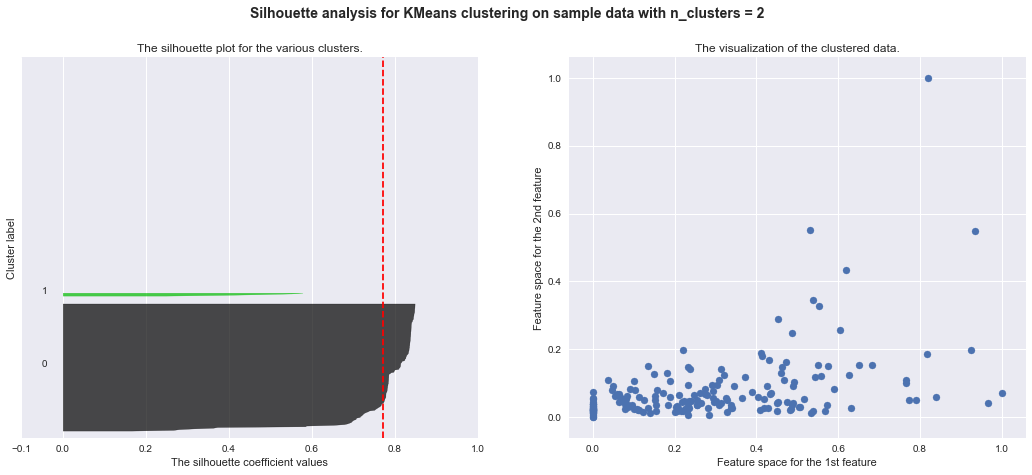

For n_clusters = 3 The average silhouette_score is : 0.525060483821


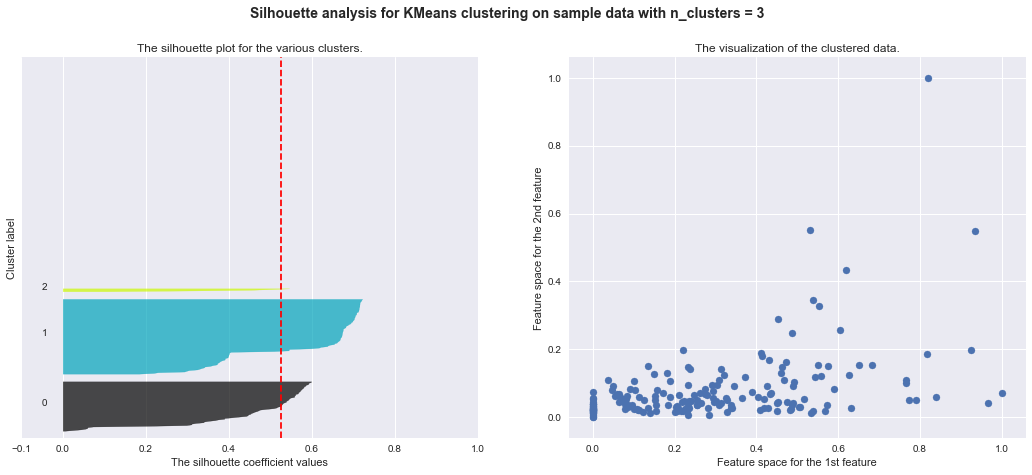

For n_clusters = 4 The average silhouette_score is : 0.511590766382


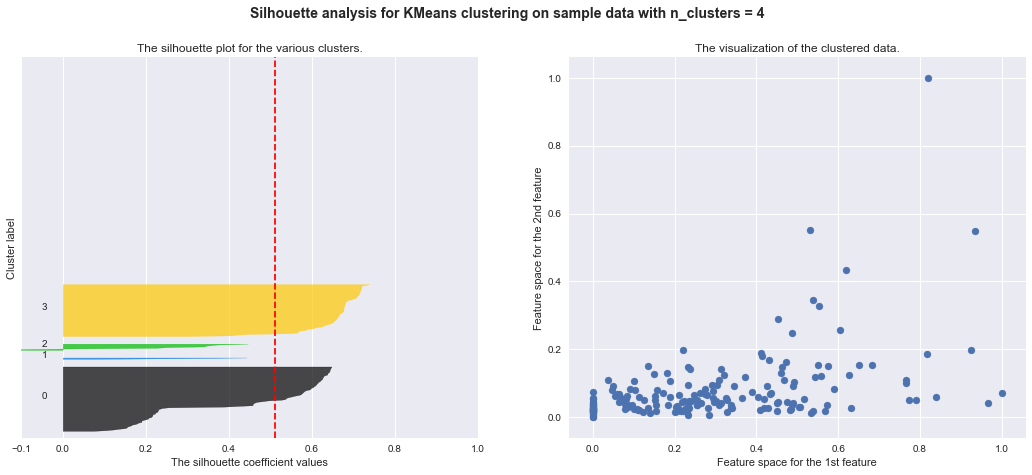

For n_clusters = 5 The average silhouette_score is : 0.474869960737


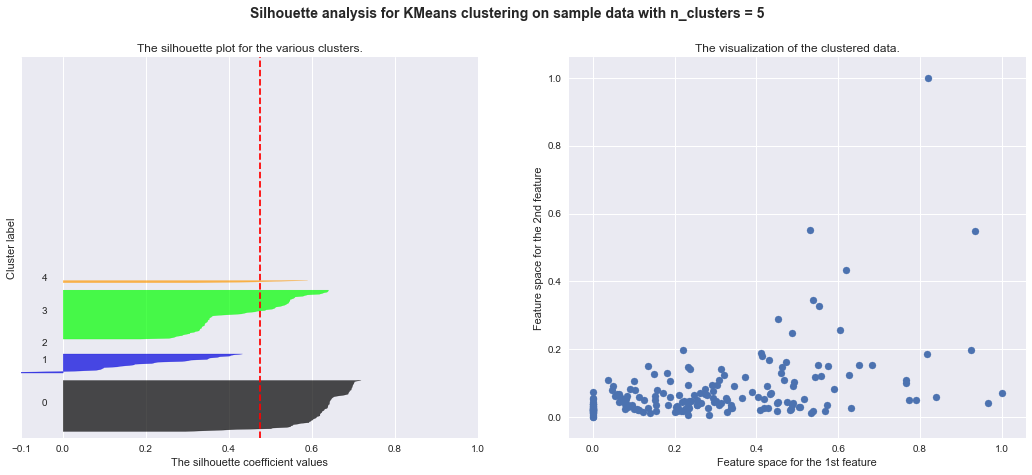

For n_clusters = 6 The average silhouette_score is : 0.448461747791


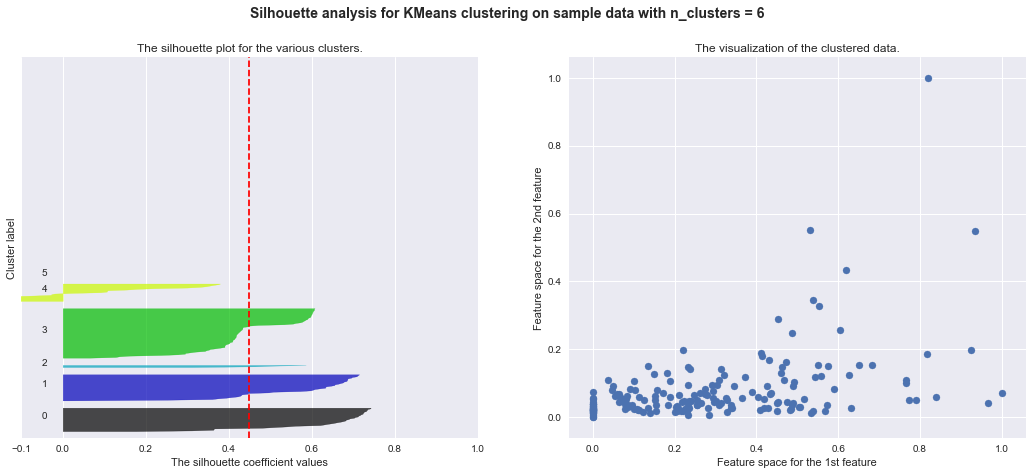

In [618]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(tb_signifi[which_columns].values)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(tb_signifi[which_columns].values, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(tb_signifi[which_columns].values, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tb_signifi['taxa_homicidio'], tb_signifi[which_columns[0]])

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [619]:
#clusterizacao escolhida
model = KMeans(n_clusters=3).fit(tb_signifi[which_columns].values)
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [620]:
from sklearn.metrics import silhouette_score, silhouette_samples
#print(silhouette_samples(df[['x','y']].values,model.labels_))
print(silhouette_score(tb_signifi[which_columns].values,model.labels_))

0.525060483821


In [621]:
clusters = pd.DataFrame(c)

In [622]:
which_columns.append('municipio')
which_columns.append('taxa_homicidio')

0 pessoas_de_10_anos_ou_mais_de_idade_grupos_de_anos_de_estudo_1_a_3_anos
1 pessoas_de_10_anos_ou_mais_de_idade_empregadas_no_trabalho_principal_da_semana_de_referencia_subgrupo_do_emprego_no_trabalho_principal_trabalhadores_domesticos_categoria_do_emprego_no_trabalho_principal__sem_carteira_de_trabalho_assinada
2 pessoas_de_10_anos_ou_mais_de_idade_empregadas_no_trabalho_principal_da_semana_de_referencia_subgrupo_do_emprego_no_trabalho_principal_demais_empregados_categoria_do_emprego_no_trabalho_principal__outros_sem_carteira_de_trabalho_assinada_(1)
3 valor_do_rendimento_nominal_mediano_mensal_do_trabalho_principal_das_pessoas_de_10_anos_ou_mais_de_idade_ocupadas_na_semana_de_referencia_com_rendimento_no_trabalho_principal_(r$)__posicao_na_ocupacao_no_trabalho_principal_empregados_categoria_do_emprego_no_trabalho_principal_outros_sem_carteira_de_trabalho_assinada_(1)


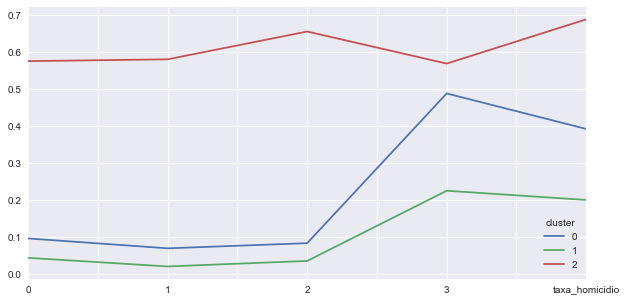

In [623]:
df_kmeans_4 = pd.concat([tb_signifi.reset_index()[which_columns], clusters], axis=1)
df_kmeans_4.set_index('municipio', inplace=True)
df_kmeans_group = df_kmeans_4.groupby(['cluster']).mean()
rename_columns = {}
for i,column in enumerate(df_kmeans_group.columns):
    if (column != 'taxa_homicidio'):
        rename_columns[column] = i
        print(i, column)
df_kmeans_group.rename(columns=rename_columns).T.plot(figsize=(10,5))

In [628]:
#municipios do cluster 0
df_kmeans_4.loc[df_kmeans_4.cluster == 0].index.values

array(['Abreu e Lima', 'Afranio', 'Agua Preta', 'Alianca', 'Aracoiaba',
       'Araripina', 'Arcoverde', 'Barra de Guabiraba', 'Barreiros',
       'Belem de Sao Francisco', 'Belo Jardim', 'Bezerros', 'Bom Jardim',
       'Brejo da Madre de Deus', 'Buenos Aires', 'Cabo de Santo Agostinho',
       'Camaragibe', 'Carpina', 'Catende', 'Cha Grande', 'Cha de Alegria',
       'Cumaru', 'Escada', 'Floresta', 'Gameleira', 'Garanhuns', 'Goiana',
       'Gravata', 'Igarassu', 'Ilha de Itamaraca', 'Ipojuca', 'Itapissuma',
       'Itaquitinga', 'Jaqueira', 'Jatoba', 'Joao Alfredo',
       'Joaquim Nabuco', 'Lagoa Grande', 'Lagoa do Carro',
       'Lagoa do Itaenga', 'Limoeiro', 'Moreno', 'Nazare da Mata',
       'Ouricuri', 'Palmares', 'Paranatama', 'Paudalho', 'Petrolandia',
       'Pombos', 'Ribeirao', 'Rio Formoso', 'Salgadinho', 'Salgueiro',
       'Santa Cruz do Capibaribe', 'Santa Maria da Boa Vista',
       'Sao Bento do Una', 'Sao Caitano', 'Sao Jose da Coroa Grande',
       'Sao Lourenco d

In [629]:
#municipios do cluster 1
df_kmeans_4.loc[df_kmeans_4.cluster == 1].index.values

array(['Afogados da Ingazeira', 'Agrestina', 'Aguas Belas', 'Alagoinha',
       'Altinho', 'Amaraji', 'Angelim', 'Belem de Maria', 'Betania',
       'Bodoco', 'Bom Conselho', 'Bonito', 'Brejao', 'Brejinho', 'Buique',
       'Cabrobo', 'Cachoeirinha', 'Caetes', 'Calcado', 'Calumbi',
       'Camocim de Sao Felix', 'Camutanga', 'Canhotinho', 'Capoeiras',
       'Carnaiba', 'Carnaubeira da Penha', 'Casinhas', 'Cedro', 'Condado',
       'Correntes', 'Cortes', 'Cupira', 'Custodia', 'Dormentes', 'Exu',
       'Feira Nova', 'Ferreiros', 'Flores', 'Frei Miguelinho',
       'Gloria do Goita', 'Granito', 'Iati', 'Ibimirim', 'Ibirajuba',
       'Iguaraci', 'Inaja', 'Ingazeira', 'Ipubi', 'Itacuruba', 'Itaiba',
       'Itambe', 'Itapetim', 'Jatauba', 'Jucati', 'Jupi', 'Jurema',
       'Lagoa do Ouro', 'Lagoa dos Gatos', 'Lajedo', 'Macaparana',
       'Machados', 'Manari', 'Maraial', 'Mirandiba', 'Moreilandia',
       'Orobo', 'Oroco', 'Palmeirina', 'Panelas', 'Parnamirim', 'Passira',
       'Pedra',

In [630]:
#municipios do cluster 2
df_kmeans_4.loc[df_kmeans_4.cluster == 2].index.values

array(['Caruaru', 'Jaboatao dos Guararapes', 'Olinda', 'Paulista',
       'Petrolina'], dtype=object)

In [631]:
# municipios_clusterizados = []
# for municipio in (df_kmeans_4.loc[df_kmeans_4.cluster != 0]).index:
#     municipios_clusterizados.append(municipio)
    
# municipios_clusterizados = tabela_final.loc[municipios_clusterizados]
# municipios_clusterizados = municipios_clusterizados.drop('Unnamed: 0', axis=1)
# municipios_clusterizados

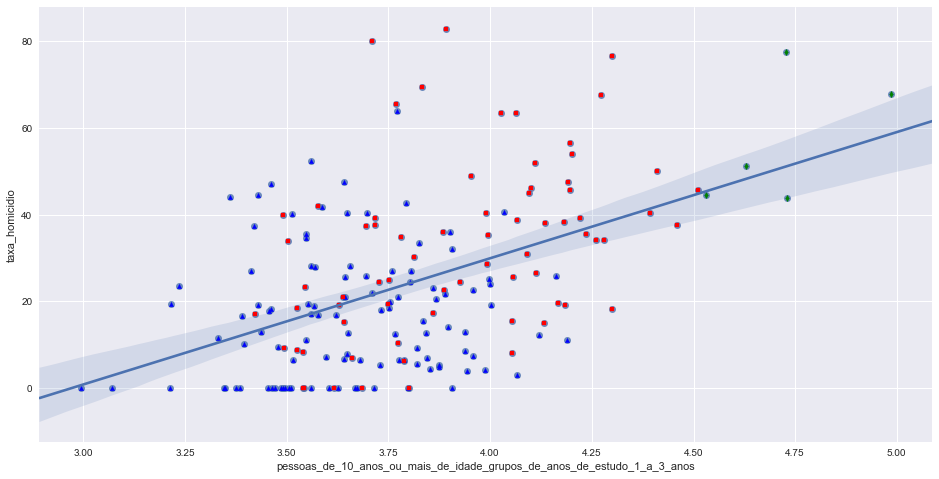

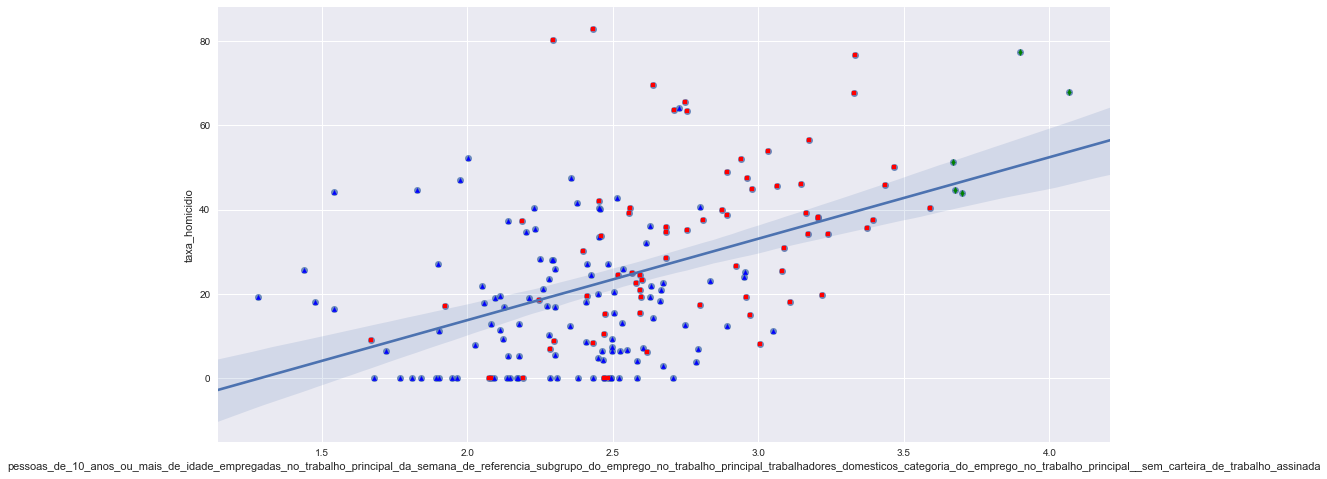

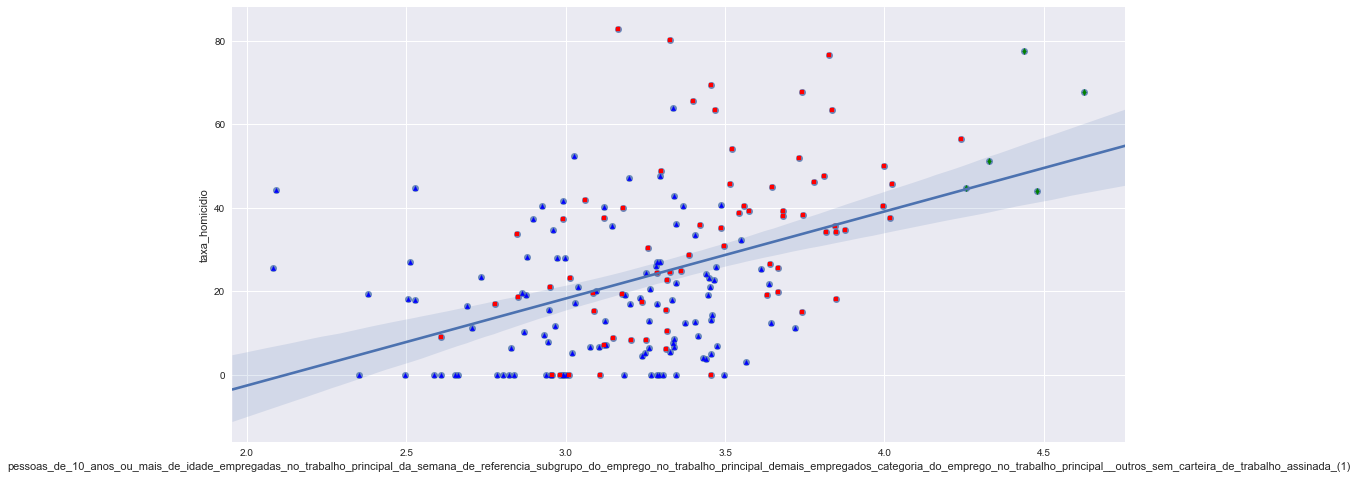

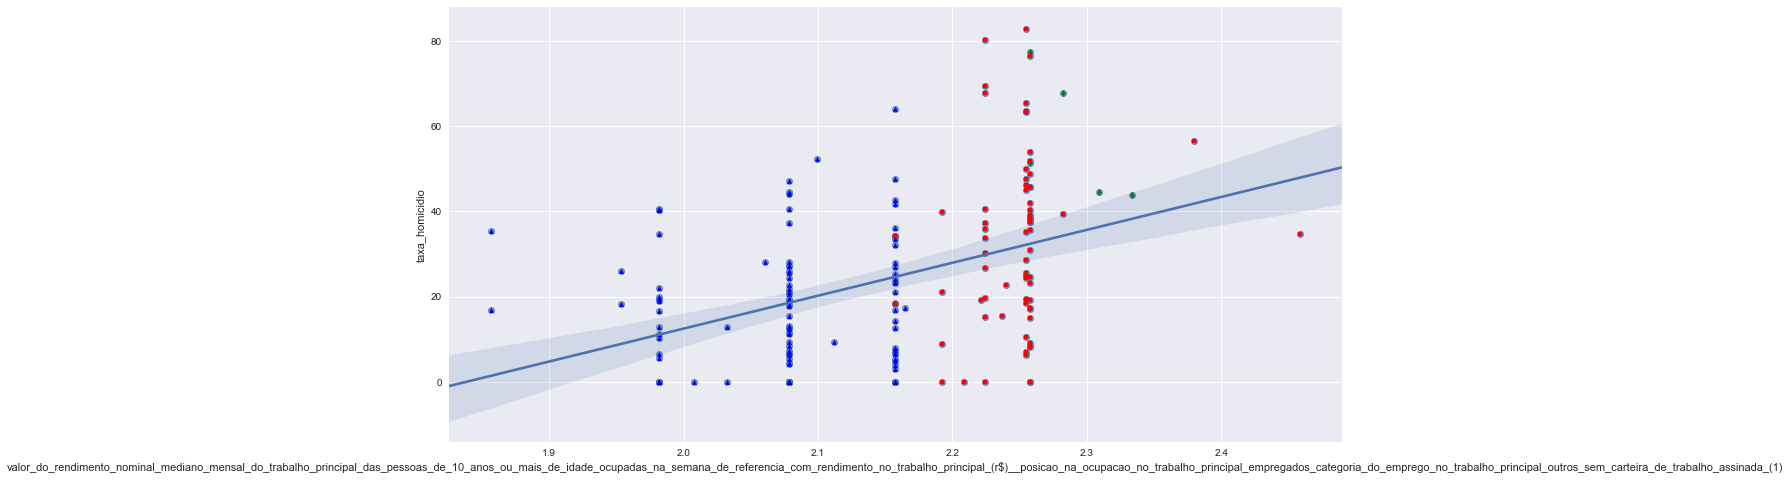

In [634]:
#visualizacao dos clusters sem normalizacao, com log
for column in [column for column in which_columns if column != 'municipio' and column != 'taxa_homicidio']:
    tb = tabela_final.copy()
    tb[column] = tb[column].apply(lambda x: x * 100000 / tb['pop'])
    tb[column] = tb[column].apply(lambda x: np.log10(x))
    plt.subplots(figsize=(16,8))
    ax = sns.regplot(column, 'taxa_homicidio',data=tb)
    clusters = np.asarray(['c{}'.format(a) for a in model.labels_],dtype='object')
    tb[clusters=='c0'].plot.scatter(x=column,y='taxa_homicidio',marker='^',color='blue', ax=ax)
    tb[clusters=='c1'].plot.scatter(x=column,y='taxa_homicidio',marker='d', color='green',ax=ax)
    tb[clusters=='c2'].plot.scatter(x=column,y='taxa_homicidio',marker='s',color='red', ax=ax)

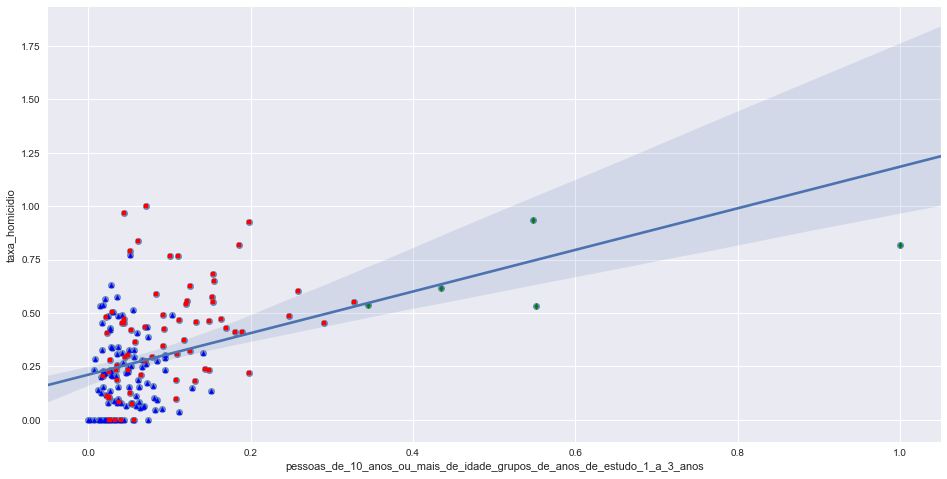

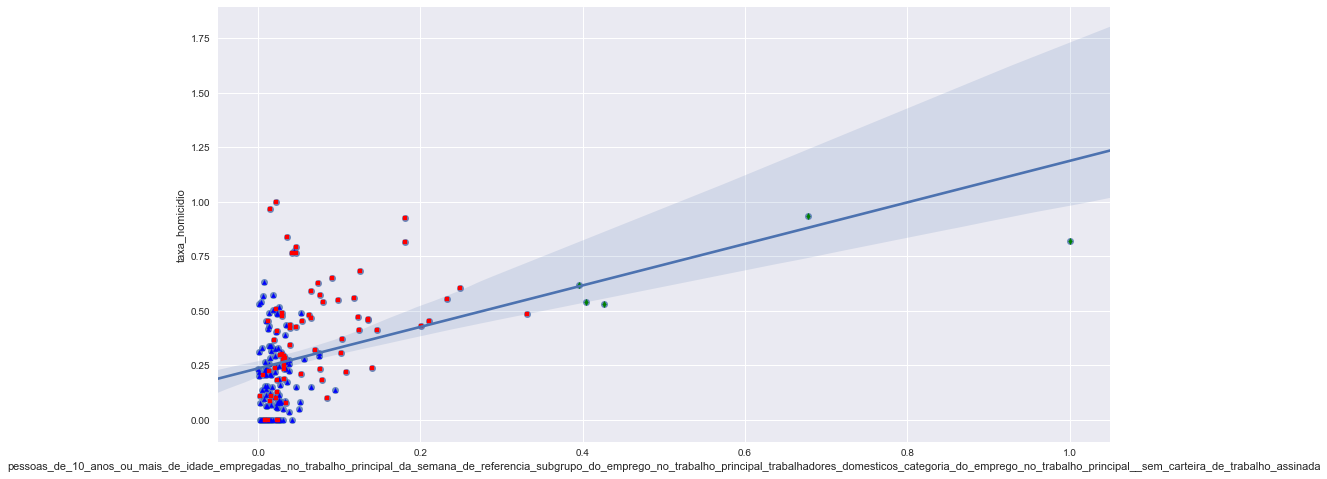

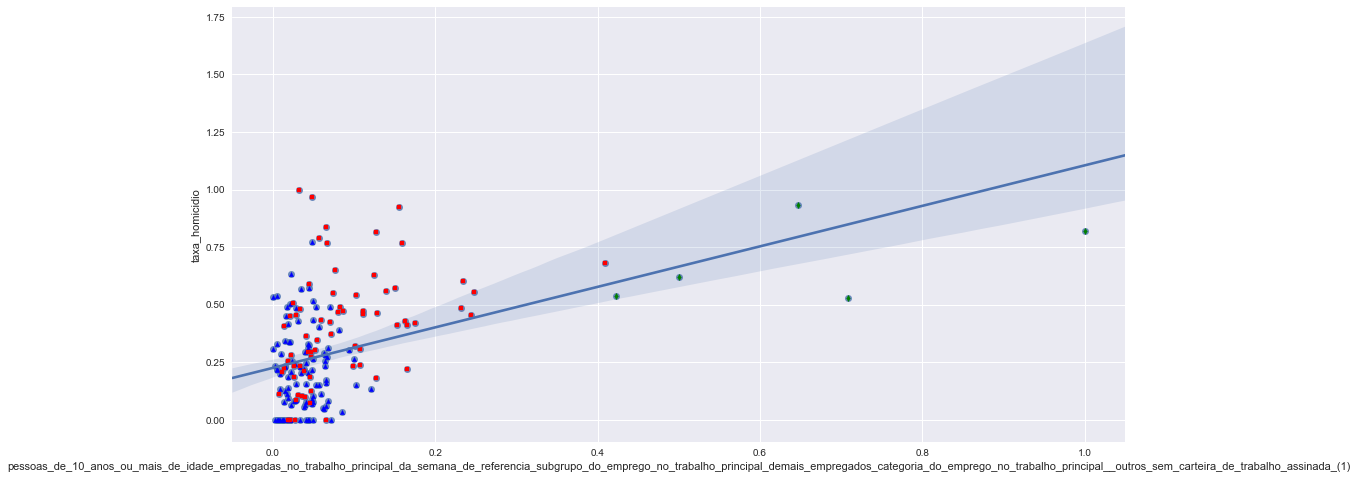

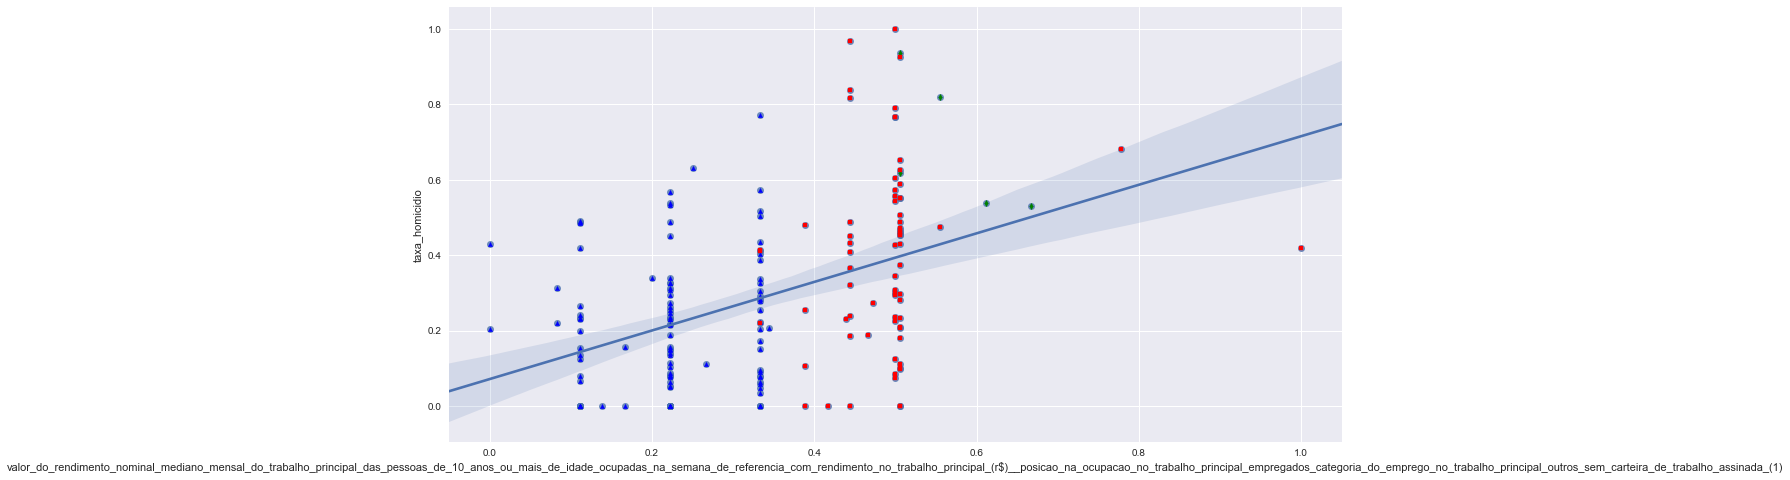

In [635]:
#visualizacao dos clusters com normalizacao, sem log
for column in [column for column in which_columns if column != 'municipio' and column != 'taxa_homicidio']:
    plt.subplots(figsize=(16,8))
    ax = sns.regplot(column, 'taxa_homicidio',data=df_kmeans_4)
    clusters = np.asarray(['c{}'.format(a) for a in model.labels_],dtype='object')
    df_kmeans_4[clusters=='c0'].plot.scatter(x=column,y='taxa_homicidio',marker='^',color='blue', ax=ax)
    df_kmeans_4[clusters=='c1'].plot.scatter(x=column,y='taxa_homicidio',marker='d', color='green',ax=ax)
    df_kmeans_4[clusters=='c2'].plot.scatter(x=column,y='taxa_homicidio',marker='s',color='red', ax=ax)

In [636]:
#df com o cluster de cada municipio
classes = pd.DataFrame(model.labels_, columns= ["class"])
classes.to_csv('classes.csv', index=False)